In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from numpy import matmul as mm
import math
from scipy.linalg import cho_factor,cho_solve

train6 = sio.loadmat('training6.mat')
sol6 = sio.loadmat('solution6.mat')

In [2]:
ball = train6['ball']; rgb = train6['rgb']; t = train6['t']
predictions = sol6['predictions']

In [3]:
def rdivide(A,B):
    c,low = cho_factor(B.T)
    C = cho_solve((c,low),A.T).T
    return C
def ldivide(A,B):
    c,low = cho_factor(A)
    C = cho_solve((c,low),B)
    return C

### Linear Modeling
#### Discrete Linear dynamical system of motion (noiseless)
$$x_{t+1}=Ax_t+Bu_t$$
$$z_t = Cx_t$$
where $x$ is the state and $z$ is the measurement.
Pos,vel,acc,rot,color,size,weight,temperature,elasticity, etc. can characterize the state.

Distance, Angle, Inertia change can be the measurement.
#### State vector $x$ of position $p$ and velocity $v$
$$x_{t+1} = [p, v=\frac{dp}{dt}]$$
#### Description of Dynamics

$$A = \begin{pmatrix}1 & dt \\ 0 & 1 \end{pmatrix}$$

### Bayesian modeling
- Prediction using state dynamics model $p(x_{t+1}|x_t)$
- Inference from noisy measurements $p(z_t|x_t)$
- $x_t\sim \mathcal{N}$

### Bayesian filtering
- Linear dynamics with noise for motion and observations

\begin{align}
p(x_{t+1}|x_t) &= Ap(x_t)+v_m = A\mathcal{N}(x_t,P_t)+\mathcal{N}(0,\Sigma_m) \\
&= \mathcal{N}(Ax_t,AP_tA^\top)+\mathcal{N}(0,\Sigma_m) \\
&= \mathcal{N}(Ax_t,AP_tA^\top+\Sigma_m)
\end{align}

\begin{align}
p(z_t|x_t) &= Cp(x_t)+v_o = C\mathcal{N}(x_t,P_t)+\mathcal{N}(0,\Sigma_o) \\
&= \mathcal{N}(Cx_t,CP_tC^\top)+\mathcal{N}(0,\Sigma_o) \\
&= \mathcal{N}(Cx_t,CP_tC^\top+\Sigma_o)
\end{align}

### Kalman Filter (Maximum A Posterior Estimation)
Consider Bayes' Rule $p(\alpha|\beta)=\frac{P(\beta|\alpha)P(\alpha)}{P(\beta)}$, where $\alpha$ is the prior and $\beta|\alpha$ is the likelihood. 

\begin{align}
p(x_t|x_{t-1}) &= \mathcal{N}(Ax_{t-1},AP_{t-1}A^\top + \Sigma_m) \rightarrow \alpha \\
p(z_t|x_t) &= \mathcal{N}(Cx_t,CP_tC^\top+\Sigma_o) \rightarrow \beta|\alpha
\end{align}

$$p(x_t|z_t,x_{t-1})=\frac{p(z_t|x_t,x_{t-1})p(x_t|x_{t-1})}{[p(z_t)}$$
where $p(x_t|z_t,x_{t-1})$ is the posterior.

- Maximum A Posteriori Estimate

\begin{align}
\hat{x}_t &= \arg\max_{x_t}p(x_t|z_t,x_{t-1})\\
 &= \arg\max_{x_t} p(z_t|x_t)p(x_t|x_{t-1})\\
 &= \arg\max_{x_t}\mathcal{N}(Cx_t,CP_tC^\top+\Sigma_o)\mathcal{N}(Ax_t,AP_tA^\top+\Sigma_m) \\
 &= \arg\max_{x_t}\mathcal{N}(Cx_t,R)\mathcal{N}(Ax_t,P)
\end{align}

### Path of the ball

(-0.17625352376802073,
 1.8881953085812642,
 -0.3021618059562813,
 0.48145729125327125)

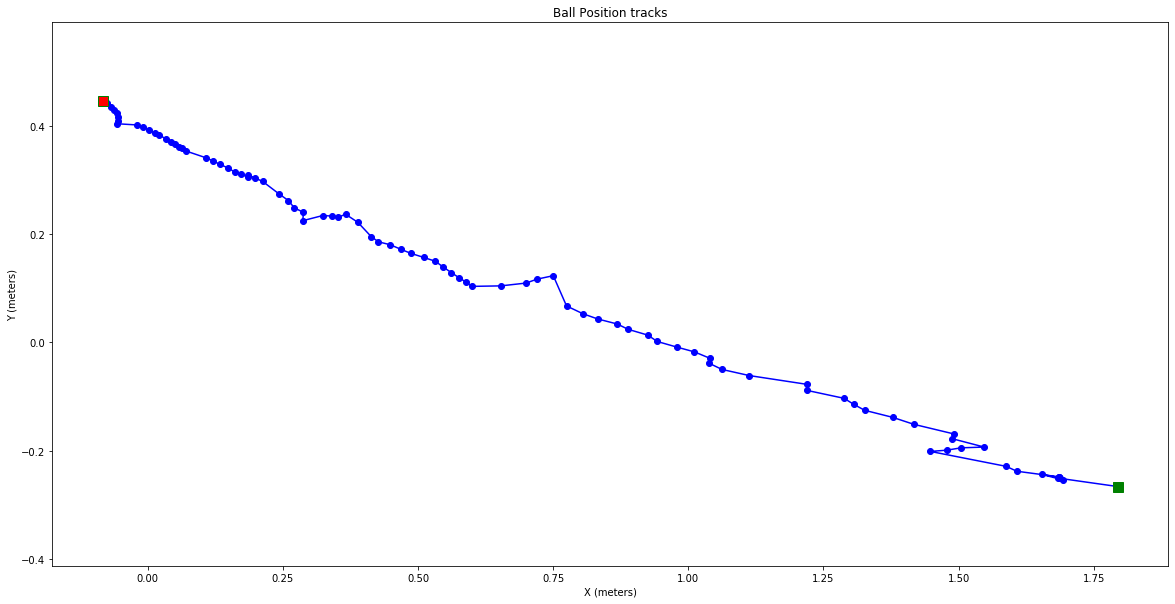

In [4]:
plt.figure(figsize=(20,10))
plt.plot(ball[0,:],ball[1,:],'bo-')
plt.plot(ball[0,-1],ball[1,-1],'s',
        markersize=10,markeredgecolor=[0,.5,0],
        markerfacecolor='r')
plt.plot(ball[0,0],ball[1,0],'s',
        markersize=10,markeredgecolor=[0,.5,0],
        markerfacecolor='g')
plt.title('Ball Position tracks')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.axis('equal')

### Run Algorithm -- Kalman Filter

In [5]:
def kalmanFilter(t,x,y,state,param,previous_t):
    dt = t-previous_t
    C = np.array([[1,0,0,0],[0,1,0,0]])
    A = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
    Af = np.array([[1,0,.33,0],[0,1,0,.33],[0,0,1,0],[0,0,0,1]])
    Sm = np.diag([.02,.001,.09,.01])
    R = np.diag([.002,.002])
    
    if previous_t < 0 :
        state = np.array([x,y,0,0])
        param['P'] = .1*np.eye(4)
        predictx = x
        predicty = y
        return predictx,predicty,state,param
    
    P = param['P']
    P = mm(mm(A,P),A.T)+Sm
    
    K = rdivide(mm(P,C.T),R+mm(mm(C,P),C.T))
    xt = state.T
    z = np.array([[x],[y]])
    x_hat = mm(A,xt).reshape(-1,1) + mm(K,z-mm(mm(C,A),xt).reshape(-1,1))
    x_f = mm(Af,xt).reshape(-1,1) + mm(K,z-mm(mm(C,Af),xt).reshape(-1,1))
    state = x_hat.T
    predictx,predicty = x_f[0],x_f[1]
    P -= mm(mm(K,C),P)
    param['P'] = P
    return predictx,predicty,state,param

In [6]:
state = np.array([0,0,0,0])
last_t,N = -1,91
myPredictions = np.zeros((2,N))
param = {}
for i in range(N):
    px,py,state,param = kalmanFilter(t[0,i],ball[0,i],
                                    ball[1,i],state,param,last_t)
    last_t = t[0,i]
    myPredictions[0,i] = px
    myPredictions[1,i] = py

(-0.1846540232445232,
 1.8885953323658595,
 -0.30337078691360453,
 0.5068458913570597)

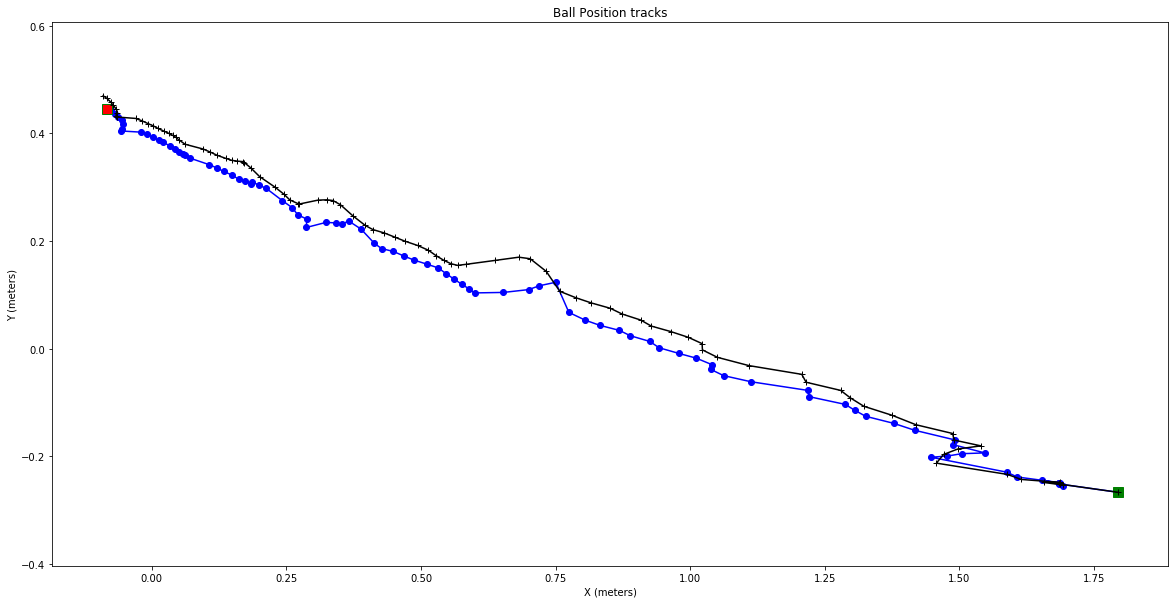

In [7]:
plt.figure(figsize=(20,10))
plt.plot(ball[0,:],ball[1,:],'bo-')
plt.plot(ball[0,-1],ball[1,-1],'s',
        markersize=10,markeredgecolor=[0,.5,0],
        markerfacecolor='r')
plt.plot(ball[0,0],ball[1,0],'s',
        markersize=10,markeredgecolor=[0,.5,0],
        markerfacecolor='g')
plt.plot(myPredictions[0,:],myPredictions[1,:],'k+-')
plt.title('Ball Position tracks')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.axis('equal')

### Show the error

Your Prediction: 0.21258471285727848


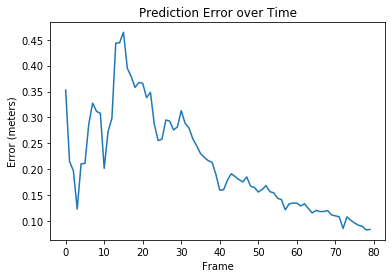

In [8]:
nSkip = 10
myError = myPredictions[:,:-11]-ball[:,nSkip:-1]
myError_dist = np.sqrt(myError[0,:]**2+myError[1,:]**2)
myError_mean = np.mean(myError_dist)

plt.plot(myError_dist)
plt.title('Prediction Error over Time')
plt.xlabel('Frame')
plt.ylabel('Error (meters)')
print('Your Prediction: '+str(myError_mean))

### Solution comparison

In [9]:
error = predictions[:,:-11]-ball[:,nSkip:-1]
error_dist = np.sqrt(error[0,:]**2+error[1,:]**2)
error_mean = np.mean(error_dist)
print('Another Kalman Prediction: '+str(error_mean))

Another Kalman Prediction: 0.14682109029351456


Text(0, 0.5, 'Error (meters)')

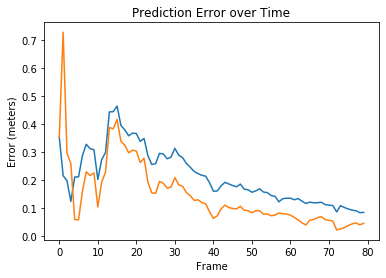

In [10]:
plt.plot(myError_dist)
plt.plot(error_dist)
plt.title('Prediction Error over Time')
plt.xlabel('Frame')
plt.ylabel('Error (meters)')

(-0.23728038344938324,
 1.8911013495184719,
 -0.30351157322871886,
 0.5098024039744603)

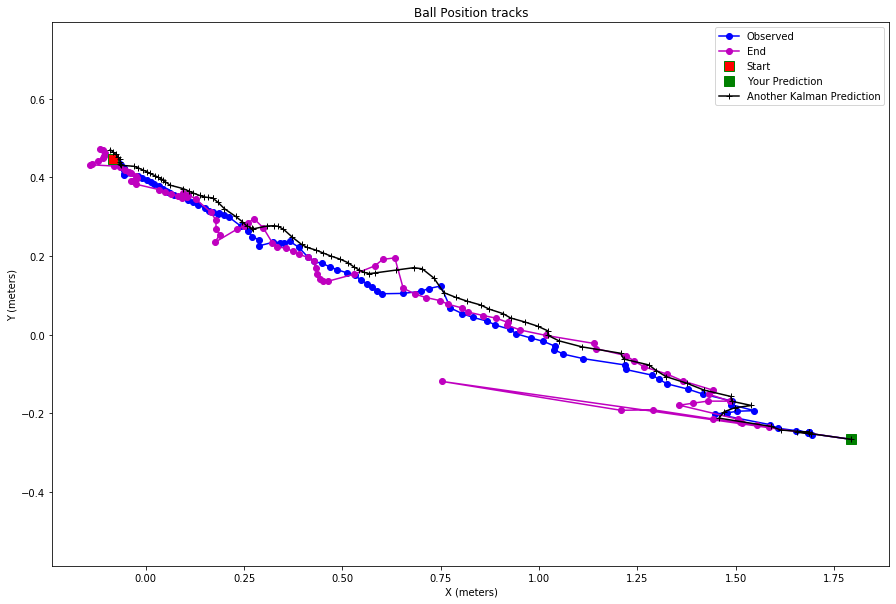

In [11]:
plt.figure(figsize=(15,10))
plt.plot(ball[0,:],ball[1,:],'bo-')
plt.plot(predictions[0,:],predictions[1,:],'mo-')
plt.plot(ball[0,-1],ball[1,-1],'s',
        markersize=10,markeredgecolor=[0,.5,0],
        markerfacecolor='r')
plt.plot(ball[0,0],ball[1,0],'s',
        markersize=10,markeredgecolor=[0,.5,0],
        markerfacecolor='g')
plt.plot(myPredictions[0,:],myPredictions[1,:],'k+-')
plt.title('Ball Position tracks')
plt.legend(['Observed','End','Start',
           'Your Prediction','Another Kalman Prediction'])
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.axis('equal')